# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight corrections to the path of light rays and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric describing motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [1]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [2]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# Improved Metric with Quantum Corrections

Here we define improved metric functions that work within the classical SC framework,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

As with the SC metric the improved metric represents a static, spherically symmetric spacetime. Spherical symmetry means we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the magnitude, defined as $L = h(r) \frac{d\phi}{d\lambda}$, is conserved. The metric is independent of 't' so energy, defined as, $E = f(r) \frac{dt}{d\lambda}$ is also conserved. If we integrate once we get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the improved metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$


In [3]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# lamda can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    # squared = g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) + (epsilon - L**2 / h(r, M, Q_c)))
    squared = g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) - (epsilon + L**2 / h(r, M, Q_c)))
    dr_dlamda = gr.s.sqrt(max(squared, 0))  # *** ensure non-negative input; obtain real part instead? ***

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# Assign Values to Constants

Assign values for Mass (M) of central massive object, Angular momentum (L) of the orbiting particle, a test value of Energy (E) and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [82]:
# block 2 - assign test values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 12 * rs1
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75
Q_c4 = 1.0

# conserved quantities
L1 = 4.3 # angular momentum of orbiting particle

# calculate and print SC metric components at a given radial distance from the BH, BH mass, and with Q_b = 0.5
f1 = f(r1, M1, Q_b2, Q_c0)
g1 = g(r1, M1, Q_b2, Q_c0)
h1 = h(r1, M1, Q_c0)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.917498561086507
g(r) = 1.09086607653130
h(r) = 576.0


# Effective Potential and Extrema

We find extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'.

In the case of light ($\epsilon = 0$) there is only a maximum at r = 3 * M when the quantum corrections (QM) = 0.

What follows is a function "find_extrema" that uses OGRePy's numerical function, nsolve to find the roots. For the case of light ($\epsilon = 0$) and a chosen value of angular momentum, L = 4.3 - a number that worked well - we can find the radial position, r, and value of $V_{\text{eff}}(r)$ at the maxima for a range of 13 $Q_b$ values between 0 and 1. Next "find_extrema" is run in a loop saving the $Q_b$ value and r, and $V_{\text{eff}}(r)$ values in an array for subsequent use in plotting trajectories. For this study we can ignore $Q_c$ (set it equal to 0) since $Q_b$ has a much larger effect and $Q_c$ is negligable by comparison. 

Finally we plot $V_{\text{eff}}(r)$ for L = 4.3 and at 13 $Q_b$ values with maximum potential (maxima) marked on the plot.

In [83]:
# block 3 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.0, Q_c = 0.0:
r = 3.7678, v_eff = 1.0803, Type: max
r = 14.7222, v_eff = 0.9379, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.25, Q_c = 0.0:
r = 3.5697, v_eff = 1.1125, Type: max
r = 15.0722, v_eff = 0.9390, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.5, Q_c = 0.0:
r = 3.3772, v_eff = 1.1501, Type: max
r = 15.4143, v_eff = 0.9401, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.75, Q_c = 0.0:
r = 3.1893, v_eff = 1.1945, Type: max
r = 15.7496, v_eff = 0.9411, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 1.0, Q_c = 0.0:
r = 3.0047, v_eff = 1.2474, Type: max
r = 16.0789, v_eff = 0.9421, Type: min


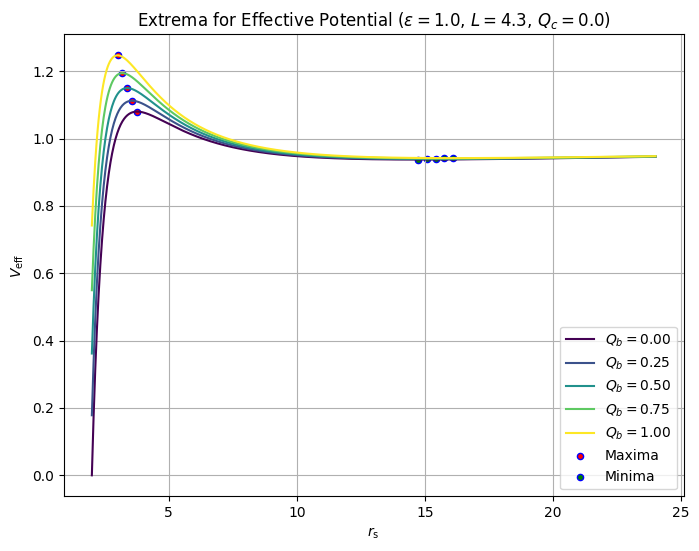

1st row of extrema data points (r, v_eff, Q_b, max/min):
[[3.7677721427714914 1.08027814593156 0.0 'max']]


In [84]:
#block 4 - find v_eff max/min for the timelike case for different values of Q_b and create array for the results
r_range = (rs1, 12 * rs1)
eps = 1.0

Q_b_vals = np.linspace(0, 1.0, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, Q_b, ext_type))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Extrema for Effective Potential ($\varepsilon={eps}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, Q_b val, extrema type
extrema_array = np.array(extrema_data)

# test print
print("1st row of extrema data points (r, v_eff, Q_b, max/min):")
print(extrema_array[:1])


In [85]:
# test code
# print v_eff max, Q_b value for given values of Q_b 
print(extrema_array[:, 0:4])

[[3.7677721427714914 1.08027814593156 0.0 'max']
 [14.722227857228507 0.937870002216587 0.0 'min']
 [3.569650797992037 1.11246547744112 0.25 'max']
 [15.072157796643065 0.939008524092140 0.25 'min']
 [3.377234168744287 1.15013595700006 0.5 'max']
 [15.414291736848671 0.940093998892989 0.5 'min']
 [3.1892770926361913 1.19454847145470 0.75 'max']
 [15.749615999809594 0.941131113700407 0.75 'min']
 [3.0046632605785986 1.24738575169174 1.0 'max']
 [16.0789389511917 0.942123905150500 1.0 'min']]


# Orbits

In this approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp' and $\lambda$ as the independent variable. This results in a list of values which can be converted to cartesian coordinates to plot y(x). We can change direction of $\frac{dr}{d\lambda}$ to list values moving inwards or heading outwards. 

Next we learn the importance of extrema. What follows is the "energy equation" we get by substituting conserved entities, L and E into the equation for $\frac{dr}{d\lambda}$ and rearranging terms,

$$
f(r) g(r) \left(\frac{dr}{d\lambda} \right)^2 + f(r) \left(\frac{L^2}{h(r)} + \epsilon \right) = E^2
$$

The 1st term corresponds to kinetic energy and 2nd term corresponds to gravitational potential energy with total energy ($E^2$) on the right-hand side. At the turning points in a circular orbit radial velocity (therefore kinetic energy) equals zero and the total energy is 100% equal to potential energy.

In the following code block we define the ODE solver function, 'solve_bound_orbit', then we set 3 sets of initial conditions ($Q_b$ = 0, 0.5, 1), run the solver, and plot each trajectory together with a plot of $V_{\text{eff}}(r)$ beside it showing the relationship between effective potential and total energy.

In [86]:
# block 5 - ODE Solver
def solve_bound_orbit(r_init, phi_init, t_init, lam_step, params, epsilon=1, max_turns=5):
    E, L, M, Q_b, Q_c = params
    eh_radius = 2 * M

    def dy_dt(lam, y, direction):
        t, r, phi = y
        r = float(r) 

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        dt_dlamda = E / ff
        dphi_dlamda = L / hh
        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))
        dr_dlamda = direction * np.sqrt(max(squared, 0))

        return [dt_dlamda, dr_dlamda, dphi_dlamda]

    y = [t_init, r_init, phi_init]
    direction = -1  # start out inwards
    lam = 0
    lam_total = 0
    r_vals, phi_vals = [r_init], [phi_init]

    turn_count = 0
    while turn_count < max_turns:
        print(turn_count) # debugging step
        # Integrate one step
        sol = solve_ivp(
            lambda lam, y: dy_dt(lam, y, direction),
            (lam, lam + lam_step),
            y,
            atol=1e-8,
            rtol=1e-8,
            max_step=0.05 # this determines the resolution of the plot
        )

        if sol.status < 0 or len(sol.t) < 2:
            print("Integration failed or produced no steps.")
            break

        r_sol = sol.y[1]
        phi_sol = np.unwrap(sol.y[2])
        r_vals.extend(r_sol[1:])
        phi_vals.extend(phi_sol[1:])

        r_end = r_sol[-1]
        if r_end <= eh_radius + 1e-4:
            print("Particle crossed the event horizon.")
            break

        # turning point check 
        t_end, r_end, phi_end = sol.y[:, -1]
        ff = f(r_end, M, Q_b, Q_c)
        gg = g(r_end, M, Q_b, Q_c)
        hh = h(r_end, M, Q_c)
        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 1e-6:
            direction *= -1
            turn_count += 1

        lam = sol.t[-1]
        y = sol.y[:, -1]

    return np.array(r_vals), np.array(phi_vals)

0
1
2
3
4


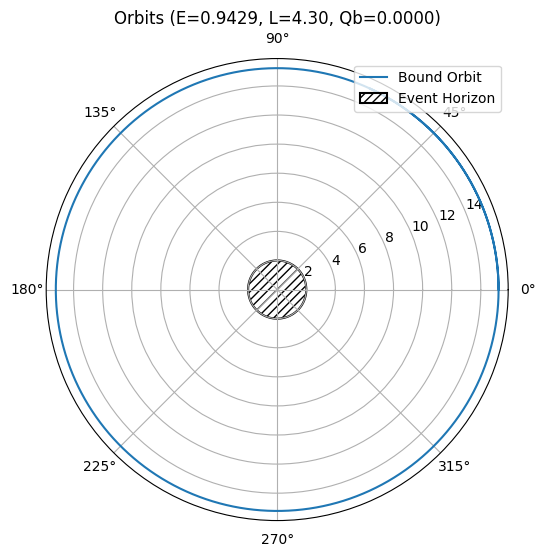

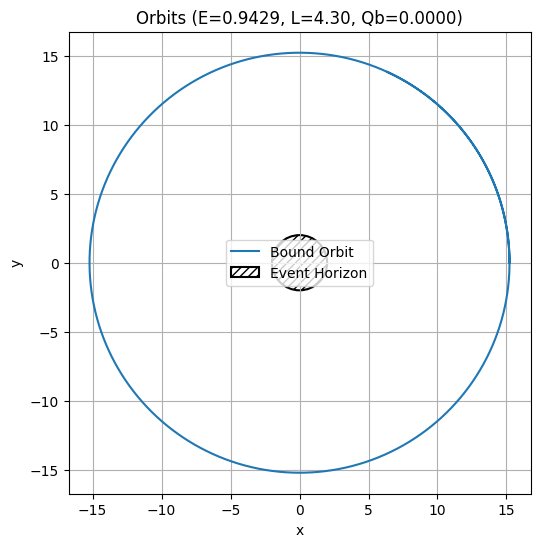

In [87]:
# Block 6 - plot bound orbits
# initial conditions
r1_1 = float(extrema_array[1, 0])
E1_1 = float(extrema_array[1, 1])
E_val1 = E1_1 + 0.005
Qb_val1 = float(extrema_array[1, 2])

L_val1 = L1
eh_radius = 2 * M1

lam_step1 = 80
r_init1 = r1_1 + 0.5
phi_init1 = 0.0
t_init1 = 0.0

params1 = (E_val1, L_val1, M1, Qb_val1, Q_c0)

# solve the bound orbit
r_vals1, phi_vals1 = solve_bound_orbit(r_init1, phi_init1, t_init1, lam_step=lam_step1, params=params1)

# polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(phi_vals1, r_vals1, label='Bound Orbit')
circle_theta = np.linspace(0, 2*np.pi, 500)
ax.fill(circle_theta, np.full_like(circle_theta, eh_radius), edgecolor='black', facecolor='none', hatch='////', linewidth=1.5, label='Event Horizon')
plt.title(f"Orbits (E={E_val1:.4f}, L={L_val1:.2f}, Qb={Qb_val1:.4f})")
ax.legend(loc='upper right')
plt.show()

# cartesian Plot
x_orbit1 = r_vals1 * np.cos(phi_vals1)
y_orbit1 = r_vals1 * np.sin(phi_vals1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_orbit1, y_orbit1, label='Bound Orbit')
ax.add_patch(plt.Circle((0, 0), eh_radius, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5, label='Event Horizon'))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
plt.title(f"Orbits (E={E_val1:.4f}, L={L_val1:.2f}, Qb={Qb_val1:.4f})")
ax.legend()
ax.grid(True)
plt.show()

# Particle Orbits ($\epsilon$ = 1) with Quantum Corrections

For M = 1.0 and L = 4.3 there is the possibility for a bound orbit close to the $V_{\text{eff}}(r)$ minima if the total energy of the particle is just above the minima. If ($Q_b$ = 0) a minimum exists at 14.72; if ($Q_b$ = 0.5) a minimum exists at 15.41; and if ($Q_b$ = 1.0) a mimumum exists at 16.08. As $Q_b$ increases from 0 to 1 the minima are located at larger r and at higher values of $V_{\text{eff}}(r)$. 

Next: using the array of minima for $V_{\text{eff}}(r)$ for different values of $Q_b$ we can pinpoint the r values where a bound orbit can be and observe and plot orbital precession.

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


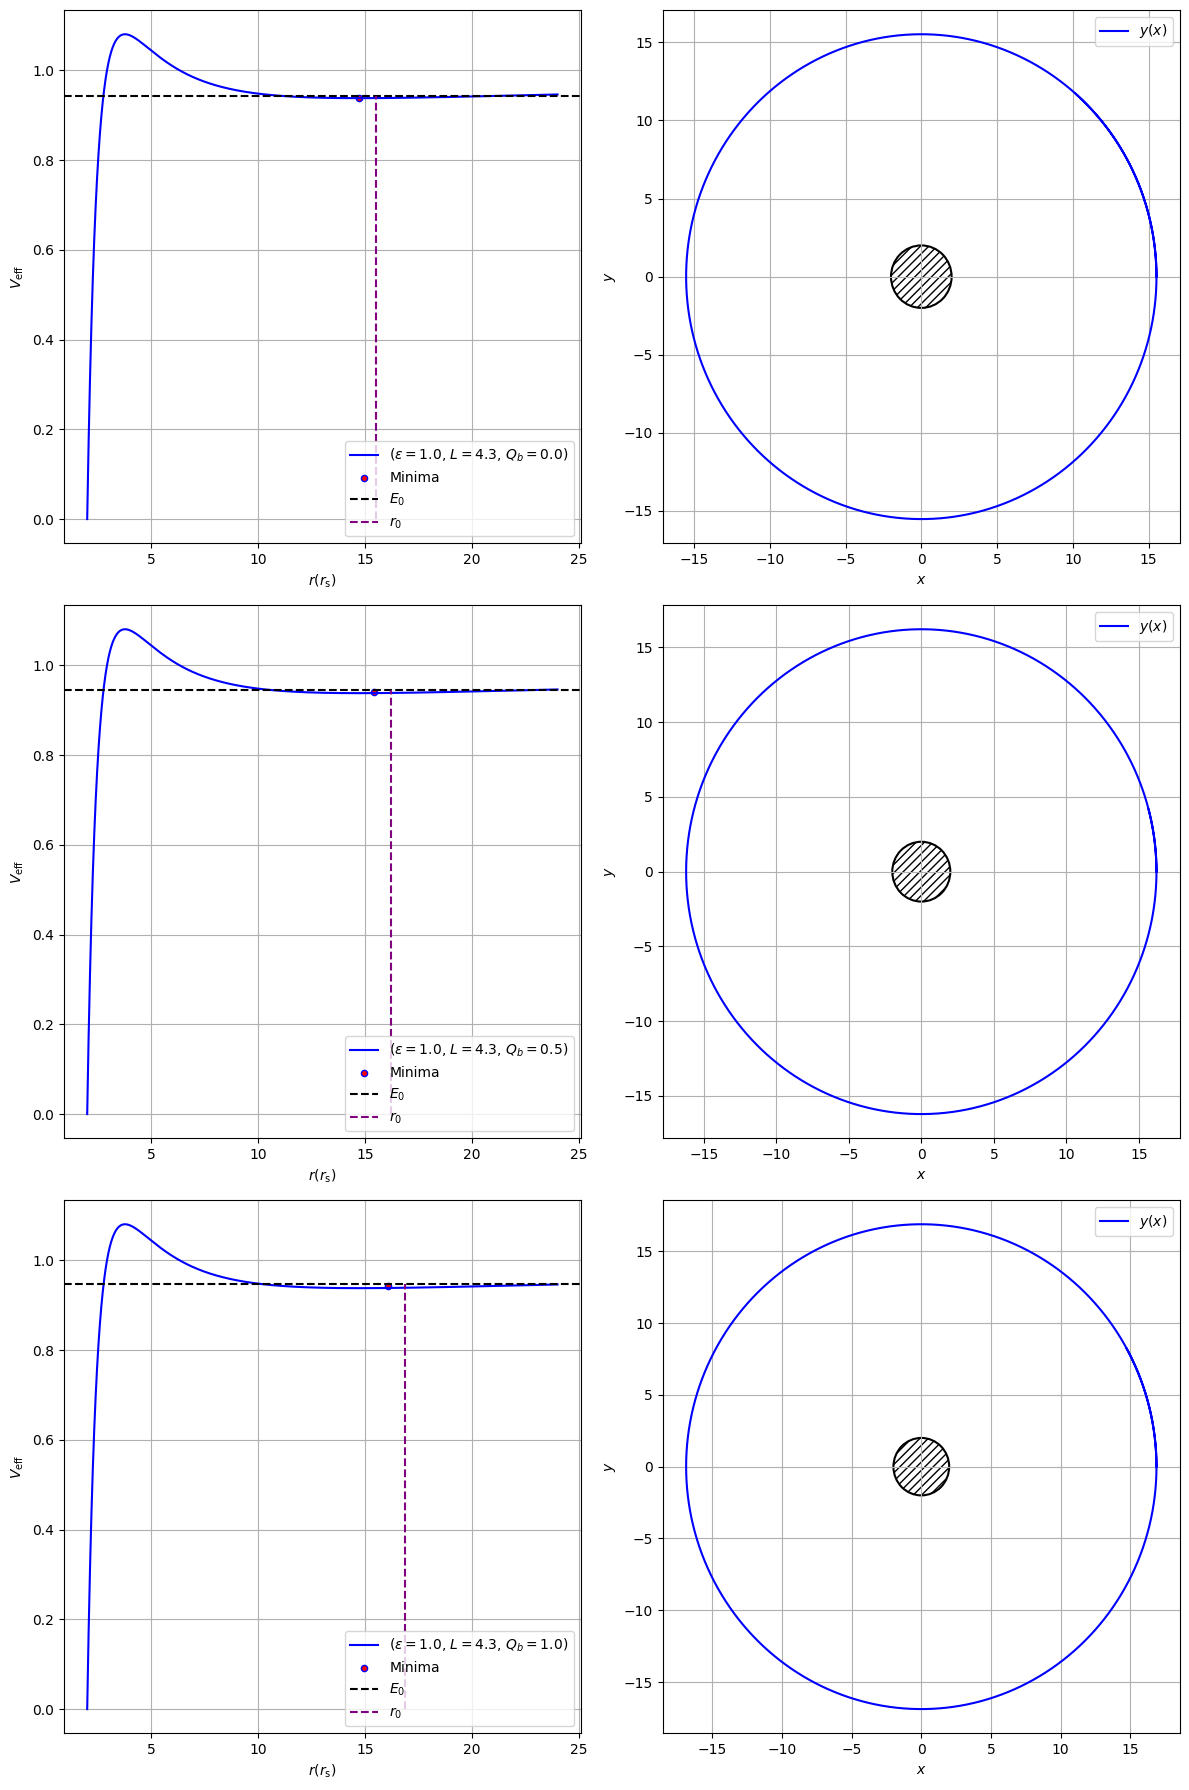

In [88]:
# block 7 - finding bound plots for time-like case (epsilon = 1)
phi_init = 0.0
t_init = 0.0
lam_step1 = 80
lam_step2 = 90
r_out = 12 * rs1 # far out starting point
eps = 1.0
#----------- Q_b = 0 ------------------#
Qb_val2 = float(extrema_array[1, 2])
r_init2 = float(extrema_array[1, 0]) + 0.8
E_val2 = float(extrema_array[1, 1]) #v_eff at max (= E)
E_val22 = E_val2 + 0.005
params2 = (E_val22, L1, M1, Qb_val2, Q_c0)

r_2 = np.linspace(rs1, 12*rs1, 1000)
v_eff_2 = np.array([v_eff(i, M1, L1, Qb_val2, Q_c0, epsilon=1) for i in r_2])

r_vals2, phi_vals2 = solve_bound_orbit(r_init2, phi_init, t_init, lam_step=lam_step1, params=params2)

# cartesian coordinates
x_vals2 = r_vals2 * np.cos(phi_vals2)
y_vals2 = r_vals2 * np.sin(phi_vals2)

#---------- Q_b = 0.5 -------------
Qb_val3 = float(extrema_array[5, 2])
r_init3 = float(extrema_array[5, 0]) + 0.8
E_val3 = float(extrema_array[5, 1]) #v_eff at max (= E)
E_val33 = E_val3 + 0.005
params3 = (E_val33, L1, M1, Qb_val3, Q_c0)

r_vals3, phi_vals3 = solve_bound_orbit(r_init3, phi_init, t_init, lam_step=lam_step1, params=params3)

# cartesian coordinates
x_vals3 = r_vals3 * np.cos(phi_vals3)
y_vals3 = r_vals3 * np.sin(phi_vals3)

#---------- Q_b = 1.0 -------------
Qb_val4 = float(extrema_array[9, 2])
r_init4 = float(extrema_array[9, 0]) + 0.8
E_val4 = float(extrema_array[9, 1])
E_val44 = E_val4 + 0.005
params4 = (E_val44, L1, M1, Qb_val4, Q_c0)

r_vals4, phi_vals4 = solve_bound_orbit(r_init4, phi_init, t_init, lam_step=lam_step2, params=params4)

# cartesian coordinates
x_vals4 = r_vals4 * np.cos(phi_vals4)
y_vals4 = r_vals4 * np.sin(phi_vals4)
#--------- Plots -------------
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# First plot
axes[0, 0].plot(r_2, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='b')
axes[0, 0].scatter(extrema_array[1,0], extrema_array[1,1], color='r', s=20, edgecolors='b', label="Minima")
axes[0, 0].axhline(y=E_val22, color='black', linestyle='--', label=r'$E_0$')
axes[0, 0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_val22, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals2, y_vals2, label=r'$y(x)$', color='blue')
circle1_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle1_1)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_2, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val3}$)", color='b')
axes[1, 0].scatter(extrema_array[5,0], extrema_array[5,1], color='r', s=20, edgecolors='b', label="Minima")
axes[1, 0].axhline(y=E_val33, color='black', linestyle='--', label=r'$E_0$')
axes[1, 0].vlines(x=r_init3, ymin=min(v_eff_2), ymax=E_val33, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals3, y_vals3, label=r'$y(x)$', color='blue')
circle2_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle2_1)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_2, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='b')
axes[2, 0].scatter(extrema_array[9,0], extrema_array[9,1], color='r', s=20, edgecolors='b', label="Minima")
axes[2, 0].axhline(y=E_val44, color='black', linestyle='--', label=r'$E_0$')
axes[2, 0].vlines(x=r_init4, ymin=min(v_eff_2), ymax=E_val44, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# 6th plot
axes[2, 1].plot(x_vals4, y_vals4, label=r'$y(x)$', color='blue')
circle3_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle3_1)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

plt.tight_layout()
plt.show()
#---------------------------


0
1
2
3
4


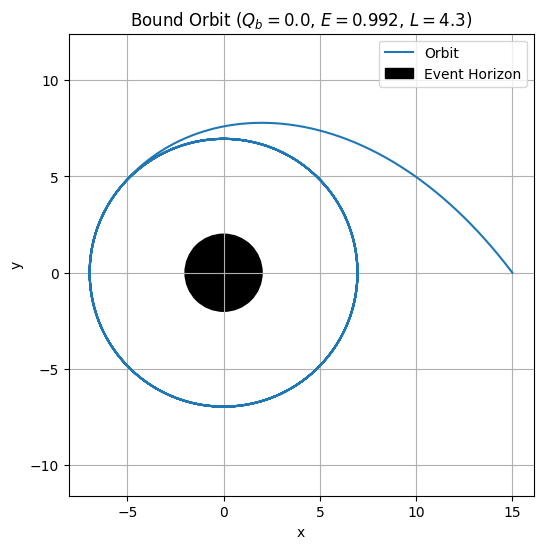

In [89]:
# Block 8 - TEST CODE to call solve_bound_orbits
r_init = 15.0
phi_init = 0.0
t_init = 0.0
lam_step = 80

# Quantum parameters
M1 = 1.0
Q_b_val = 0.0
Q_c_val = 0.0
L_val = 4.3
epsilon = 1  

# v_eff at initial r
v_eff_init = float(v_eff(r_init, M1, L_val, Q_b_val, Q_c_val, epsilon))
E_val = np.sqrt(1.05 * v_eff_init)

params = (E_val, L_val, M1, Q_b_val, Q_c_val)

# solve the bound orbit
r_vals, phi_vals = solve_bound_orbit(r_init, phi_init, t_init, lam_step=lam_step, params=params)

# cartesian coords 
x_vals = r_vals * np.cos(phi_vals)
y_vals = r_vals * np.sin(phi_vals)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_vals, y_vals, label="Orbit")

from matplotlib.patches import Circle
bh = Circle((0, 0), radius=2*M1, color='black', label='Event Horizon')
ax.add_patch(bh)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Bound Orbit ($Q_b={Q_b_val}$, $E={E_val:.3f}$, $L={L_val}$)")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.show()